# Object Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [1]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()

Note: you may need to restart the kernel to use updated packages.


### Download the Surveillance Videos

In this tutorial, we focus on the UA-DETRAC benchmark. UA-DETRAC is a challenging real-world multi-object detection and multi-object tracking benchmark. The dataset consists of 10 hours of videos captured with a Cannon EOS 550D camera at 24 different locations at Beijing and Tianjin in China.

In [2]:
# Getting the video files
!wget -nc "https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1" -O ua_detrac.mp4

File ‘ua_detrac.mp4’ already there; not retrieving.


### Load the videos for analysis

We use a regular expression to load all the videos into the table in a single command

In [3]:
cursor.query("DROP TABLE IF EXISTS ObjectDetectionVideos;").df()
cursor.load(file_regex='ua_detrac.mp4', format="VIDEO", table_name='ObjectDetectionVideos').df()

,0
0,Number of loaded VIDEO: 1


### Register YOLO Object Detector as an User-Defined Function (UDF) in EvaDB 

In [4]:
cursor.query("""
            CREATE UDF IF NOT EXISTS Yolo
            TYPE  ultralytics
            'model' 'yolov8m.pt';
      """).df()

,0
0,"UDF Yolo already exists, nothing added."


### Run the YOLO Object Detector on the video

In [5]:
yolo_query = cursor.table("ObjectDetectionVideos")
yolo_query = yolo_query.filter("id < 20")
yolo_query = yolo_query.select("id, Yolo(data)")

response = yolo_query.df()
print(response)

    objectdetectionvideos.id  \
0                          0   
1                          1   
2                          2   
3                          3   
4                          4   
5                          5   
6                          6   
7                          7   
8                          8   
9                          9   
10                        10   
11                        11   
12                        12   
13                        13   
14                        14   
15                        15   
16                        16   
17                        17   
18                        18   
19                        19   

                                          yolo.labels  \
0   [car, car, car, car, car, car, person, car, ca...   
1   [car, car, car, car, car, car, car, car, perso...   
2   [car, car, car, person, car, car, car, car, ca...   
3   [car, car, car, car, car, car, person, car, ca...   
4   [car, car, car, car, car, car, person,

### Visualizing output of the Object Detector on the video

In [6]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['yolo.bboxes', 'yolo.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness) 
                # frame label
                cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
            video.write(frame)

            # Stop after twenty frames (id < 20 in previous query)
            if frame_id == 20:
                break

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()

        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

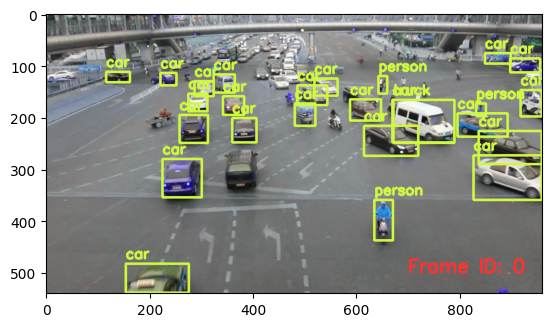

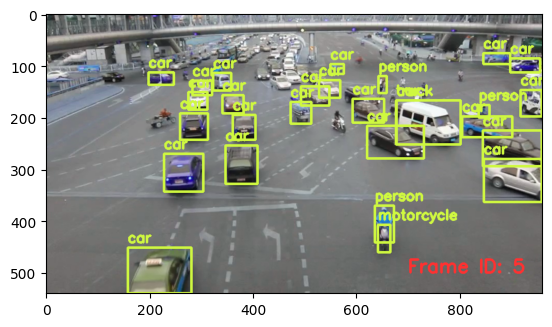

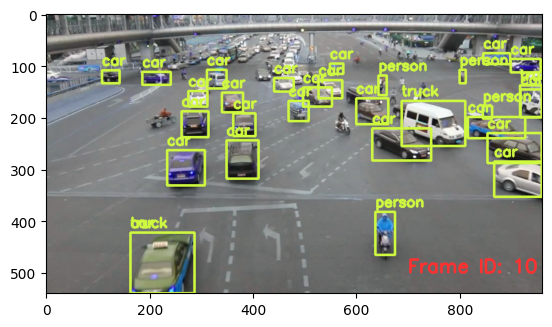

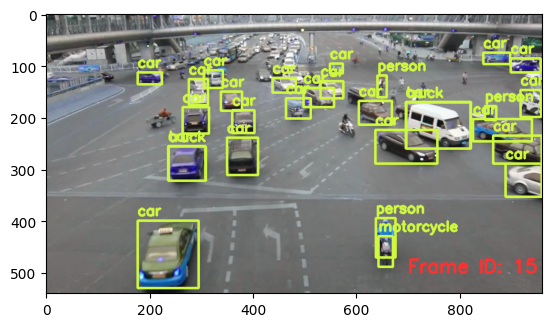

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x0b\x1c\xde...')

In [7]:
from ipywidgets import Video, Image
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

annotate_video(response, input_path, output_path)
Video.from_file(output_path)

### Drop the function if needed

In [8]:
cursor.query("DROP UDF IF EXISTS Yolo").df()

,0
0,UDF Yolo successfully dropped
